 [U-Net](https://arxiv.org/abs/1505.04597) 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import cv2
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
import tensorflow as tf
from datetime import datetime
import utils
import model

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Set some parameters
_imgWidth = 256
_imgHeight = 256
_imgChannels = 3
_trainPath = './stage1_train_fixed/'
_valPath = './extra_data/'
_testPath = './stage2_test_final/'

# Root directory of the project
_rootDir = os.getcwd()

# Directory to save logs and trained model
_modelDir = os.path.join(_rootDir, "logs")


_seed = 42
_batchSize = 8
_batchSizeGenerator = 1
_validationSplit = 0.1
_epochs = 50
_augmentedImagesNum = 300
#_augmentedImagesNum = 2*len(train_ids)

# Get the data

In [3]:
train_ids, X_train, Y_train = utils.load_dataset(_trainPath, _imgWidth, _imgHeight, _imgChannels, testData = False)

Getting and resizing images ... 


  0%|          | 0/665 [00:00<?, ?it/s]/tmp/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
 73%|███████▎  | 483/665 [02:38<00:59,  3.05it/s]

.ipynb_checkpoints


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

Done!


In [19]:
val_ids, X_val, Y_val = utils.load_dataset(_valPath, _imgWidth, _imgHeight, _imgChannels, testData = False)

Getting and resizing images ... 


/tmp/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


no failed ids
Done!


In [15]:
test_ids, X_test, sizes_test = utils.load_dataset(_testPath, _imgWidth, _imgHeight, _imgChannels, testData = True)

Getting and resizing images ... 


/tmp/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0
__pycache__
.ipynb_checkpoints


Done!



Let's see if things look all right by drawing some random images and their associated masks.


In [38]:
print(len(X_train))

664


(256, 256, 3)


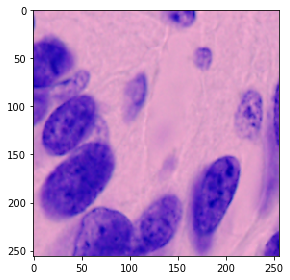

(256, 256, 1)


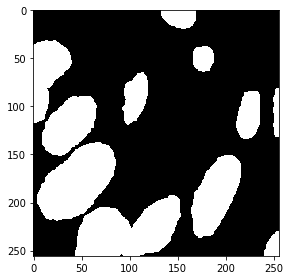

NameError: name 'val_ids' is not defined

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
print(X_train[ix].shape)
plt.show()
imshow(np.squeeze(Y_train[ix]))
print(Y_train[ix].shape)
plt.show()


# Check if validation data looks all right
ix = random.randint(0, len(val_ids))
imshow(X_val[ix])
print(X_val[ix].shape)
plt.show()
imshow(np.squeeze(Y_val[ix]))
print(Y_val[ix].shape)
plt.show()

# Augmentation

In [7]:
###augment training images and corresponding masks with keras' ImageDataGenerator class
   
trainDataGenArgs = dict(horizontal_flip=True,
                     featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)

trainImageDatagen = ImageDataGenerator(**trainDataGenArgs)
trainMaskDatagen = ImageDataGenerator(**trainDataGenArgs)
trainImageDatagen.fit(X_train, seed = _seed)
trainMaskDatagen.fit(Y_train, seed = _seed)
trainImageGenerator = trainImageDatagen.flow(X_train, batch_size=_batchSizeGenerator, shuffle=True, seed=_seed, save_to_dir=None)
trainMaskGenerator = trainMaskDatagen.flow(Y_train, batch_size=_batchSizeGenerator, shuffle=True, seed=_seed, save_to_dir=None)
#combine generators into one which yields image and masks
trainGenerator = zip(trainImageGenerator, trainMaskGenerator)

In [45]:
###Get the images and masks out of the generator and save them in lists
images = np.zeros((_augmentedImagesNum, _imgHeight, _imgWidth, _imgChannels))
masks = np.zeros((_augmentedImagesNum, _imgHeight, _imgWidth, 1), dtype=np.bool)

c = 0

for x, y in tqdm(trainGenerator, total=_augmentedImagesNum):    
    images[c] = np.squeeze(x)
    #plt.imshow(images[c])
    #print(images[c].shape)
    #print(type(images[c]))
    #plt.show()
    
    m = np.squeeze(y, axis=0)
    for i in range(0, m.shape[0]):
        for j in range(0, m.shape[1]):
            if m[i][j] <= 0:
                m[i][j] = 0.
            else:
                m[i][j] = 255.
    masks[c] = m
    #plt.imshow(np.squeeze(masks[c]))
    #plt.show()
    c+=1
    if c>=_augmentedImagesNum:
        break
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


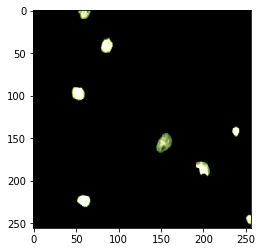

(256, 256, 1)


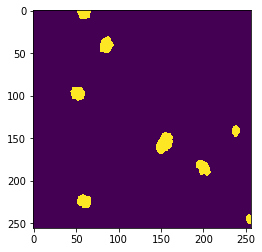

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


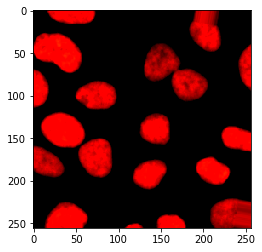

(256, 256, 1)


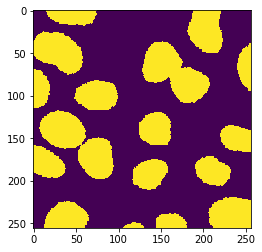

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


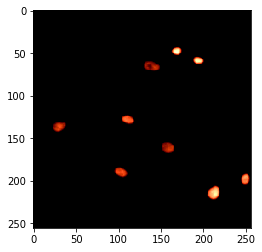

(256, 256, 1)


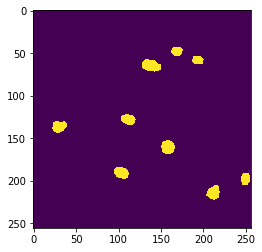

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


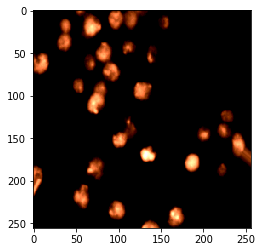

(256, 256, 1)


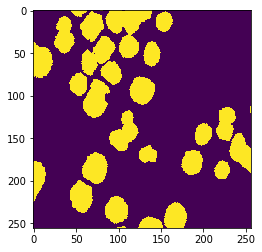

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


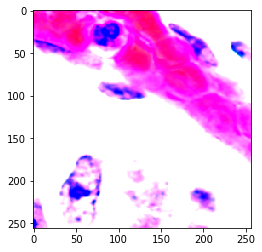

(256, 256, 1)


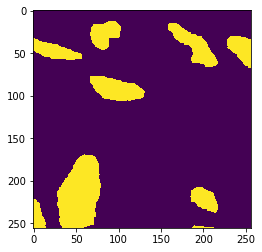

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


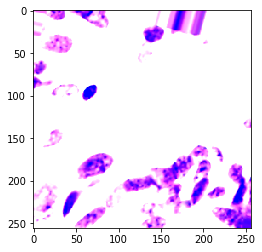

(256, 256, 1)


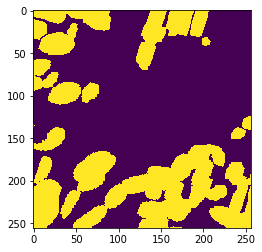

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


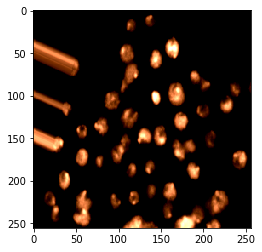

(256, 256, 1)


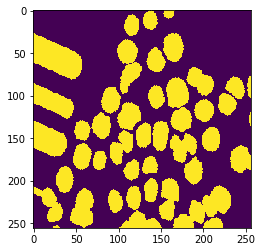

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


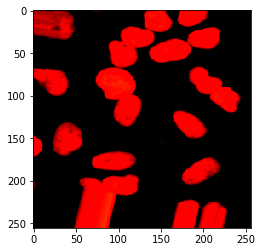

(256, 256, 1)


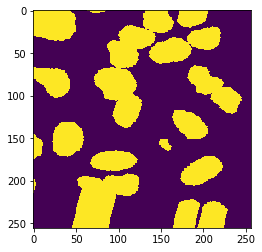

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


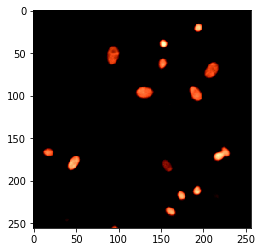

(256, 256, 1)


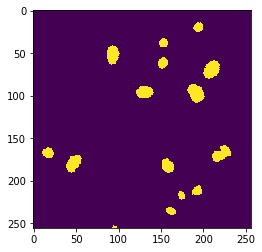

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


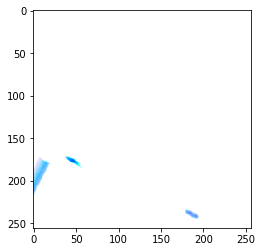

(256, 256, 1)


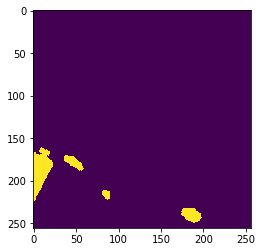

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


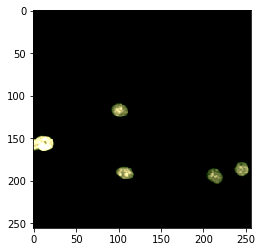

(256, 256, 1)


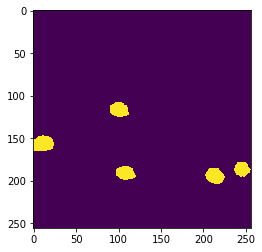

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


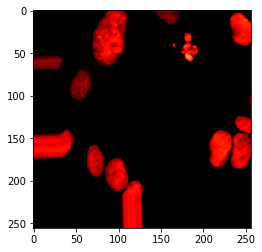

(256, 256, 1)


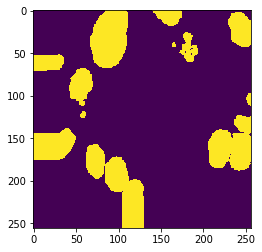

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


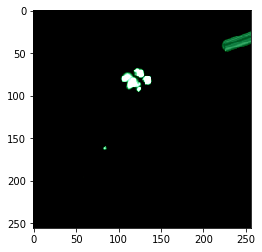

(256, 256, 1)


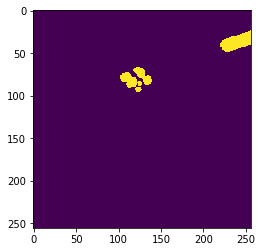

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


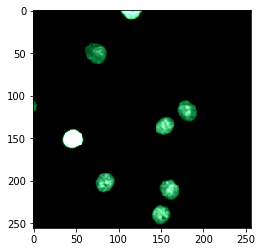

(256, 256, 1)


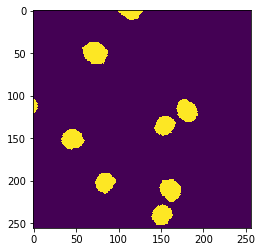

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


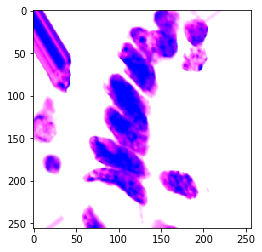

(256, 256, 1)


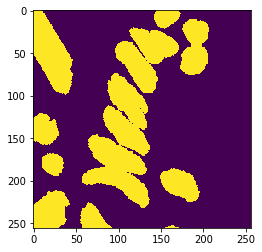

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


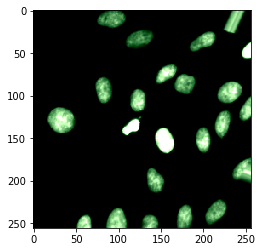

(256, 256, 1)


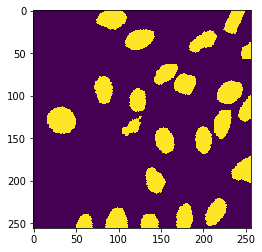

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


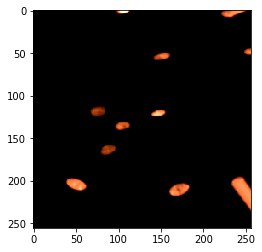

(256, 256, 1)


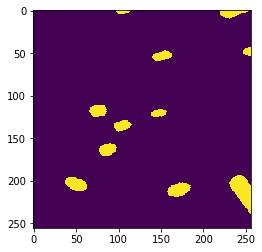

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


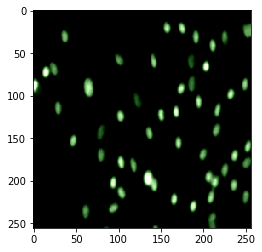

(256, 256, 1)


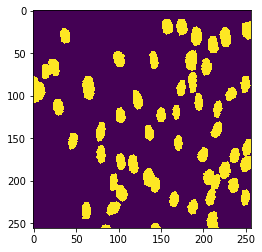

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


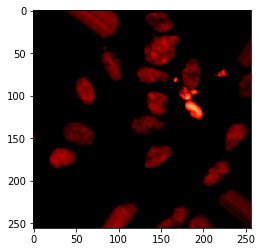

(256, 256, 1)


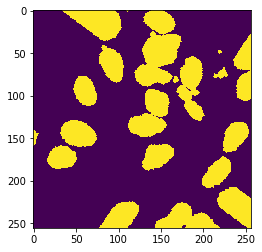

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


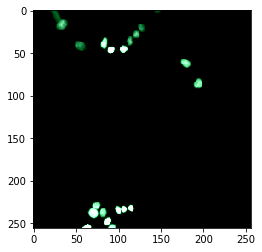

(256, 256, 1)


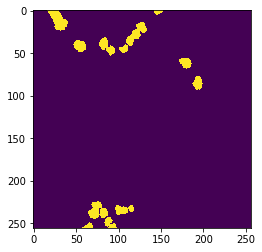

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


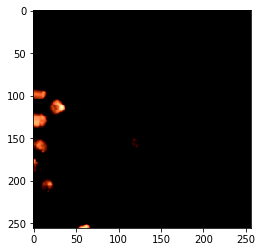

(256, 256, 1)


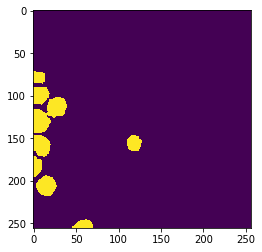

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


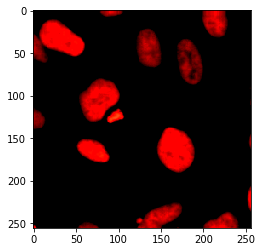

(256, 256, 1)


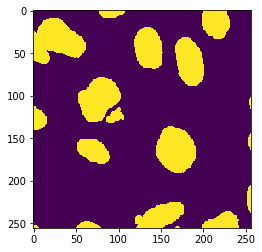

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


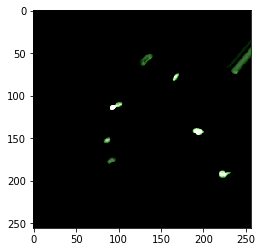

(256, 256, 1)


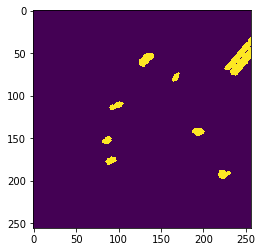

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


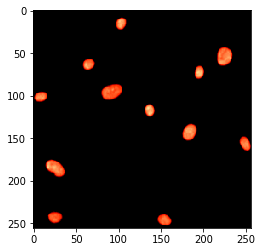

(256, 256, 1)


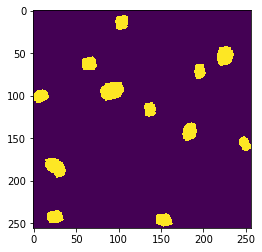

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


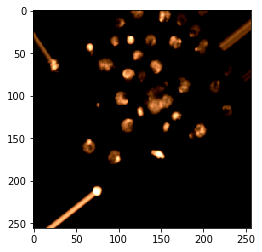

(256, 256, 1)


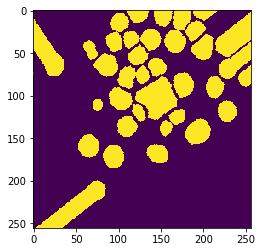

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


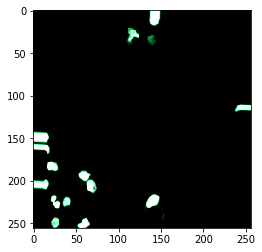

(256, 256, 1)


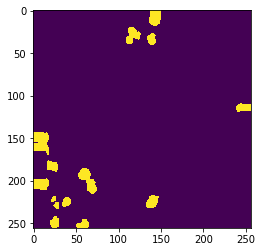

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


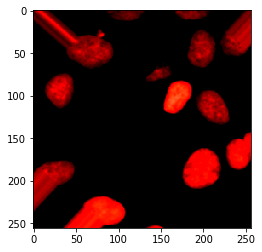

(256, 256, 1)


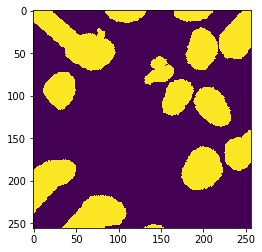

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


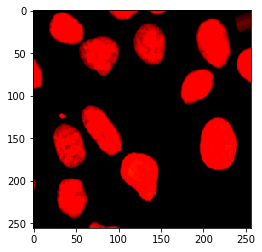

(256, 256, 1)


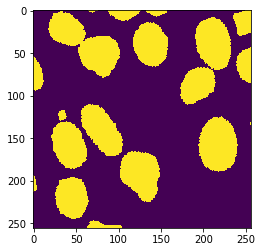

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


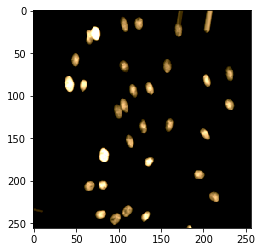

(256, 256, 1)


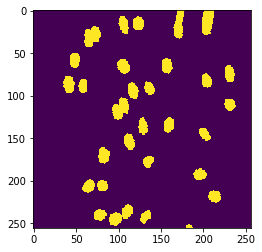

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


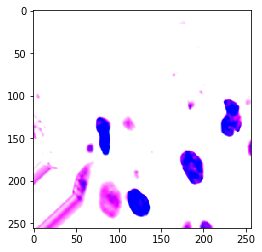

(256, 256, 1)


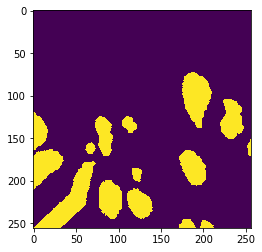

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


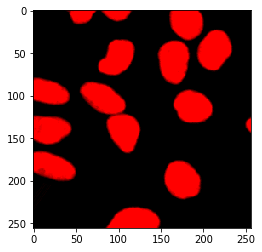

(256, 256, 1)


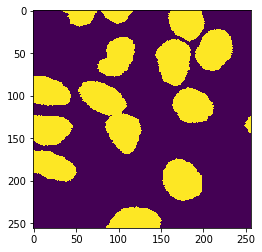

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


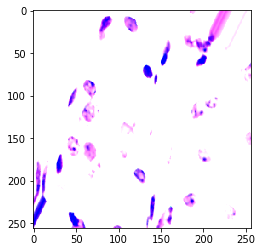

(256, 256, 1)


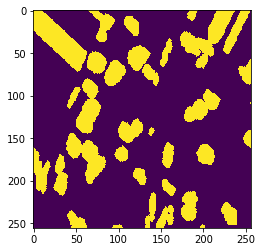

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


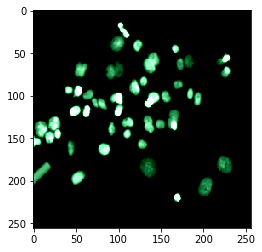

(256, 256, 1)


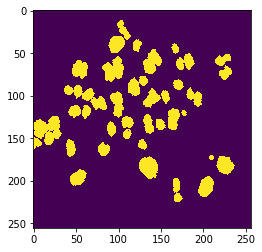

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


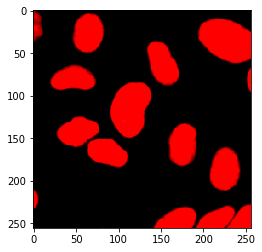

(256, 256, 1)


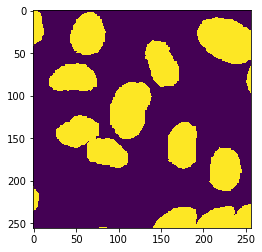

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


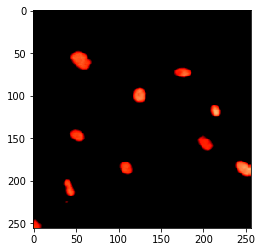

(256, 256, 1)


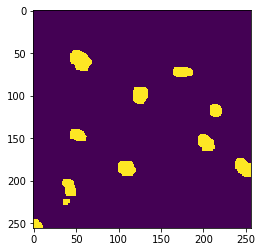

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


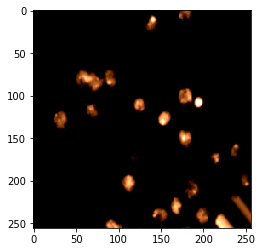

(256, 256, 1)


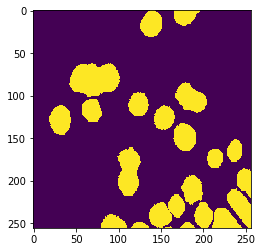

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


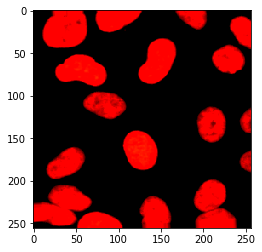

(256, 256, 1)


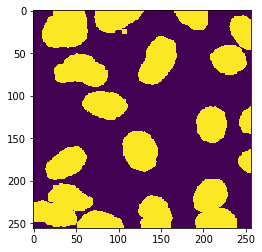

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


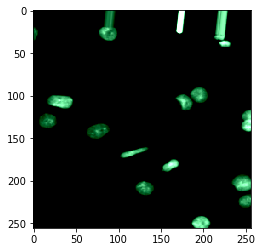

(256, 256, 1)


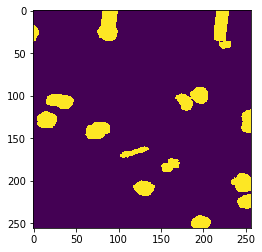

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


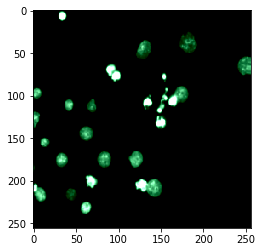

(256, 256, 1)


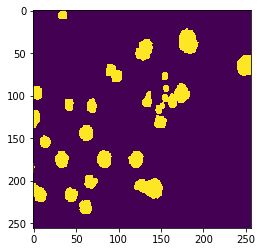

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


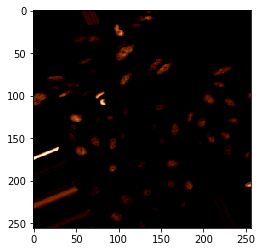

(256, 256, 1)


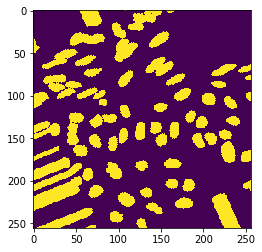

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


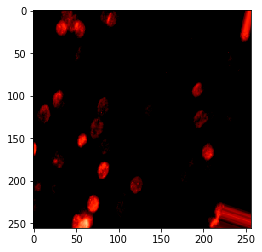

(256, 256, 1)


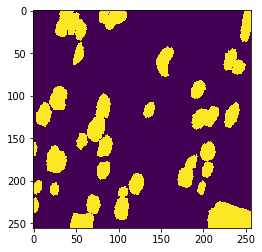

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


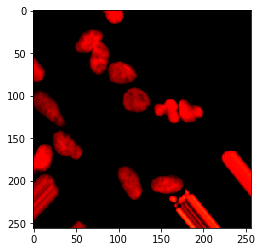

(256, 256, 1)


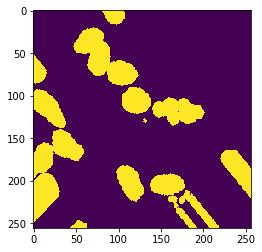

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


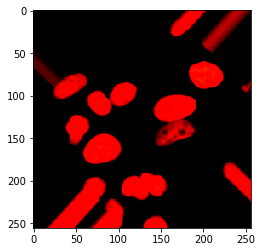

(256, 256, 1)


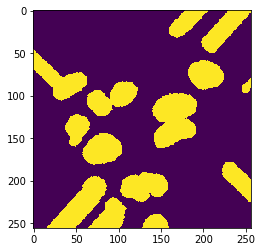

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


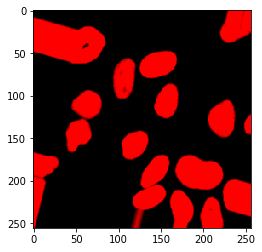

(256, 256, 1)


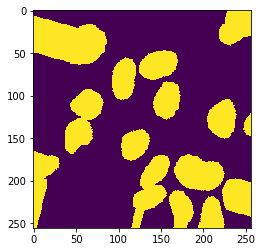

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


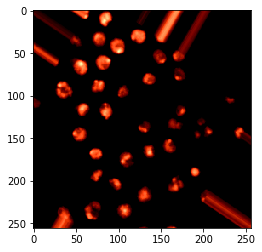

(256, 256, 1)


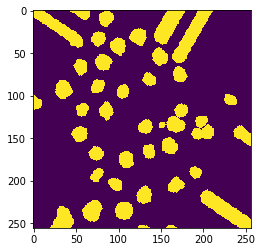

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


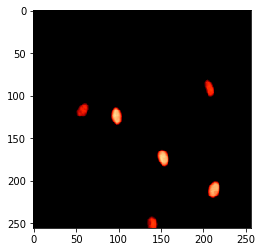

(256, 256, 1)


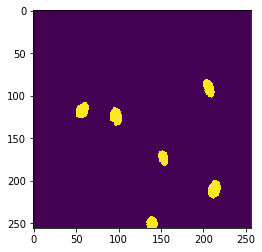

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


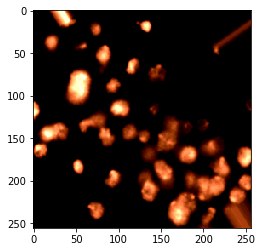

(256, 256, 1)


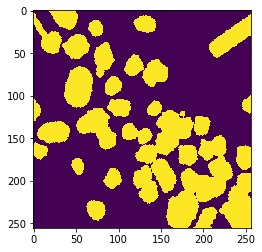

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


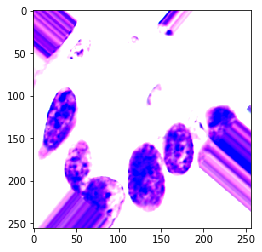

(256, 256, 1)


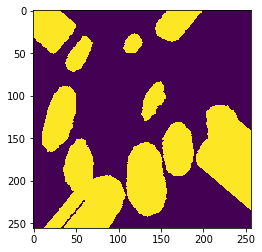

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


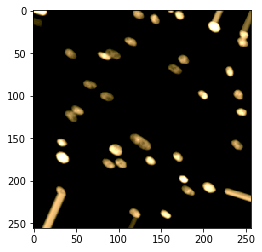

(256, 256, 1)


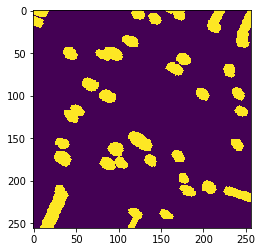

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


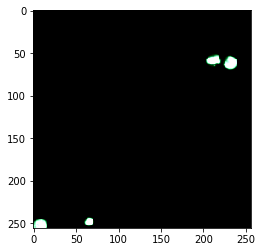

(256, 256, 1)


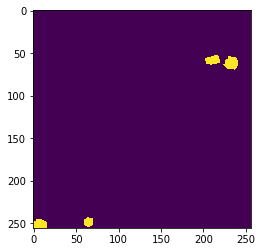

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


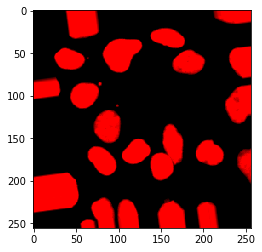

(256, 256, 1)


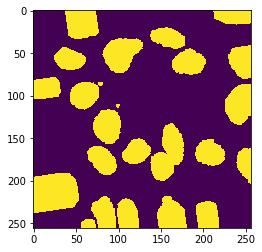

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


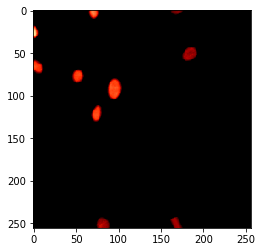

(256, 256, 1)


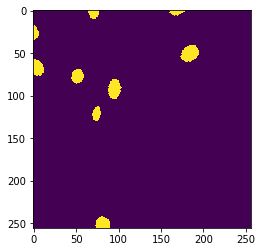

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


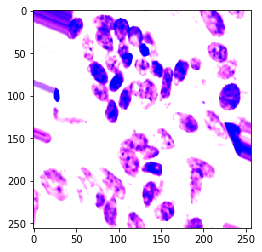

(256, 256, 1)


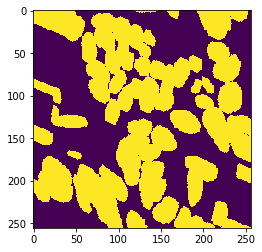

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


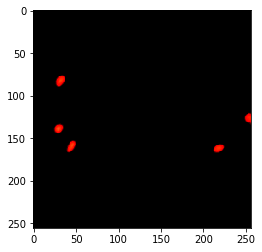

(256, 256, 1)


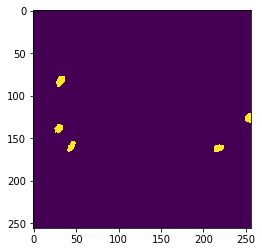

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


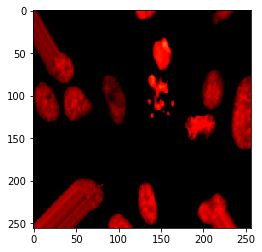

(256, 256, 1)


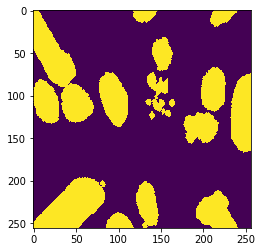

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


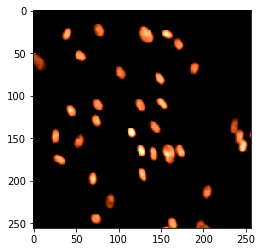

(256, 256, 1)


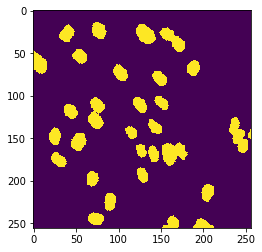

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


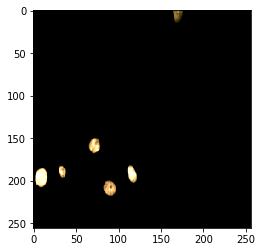

(256, 256, 1)


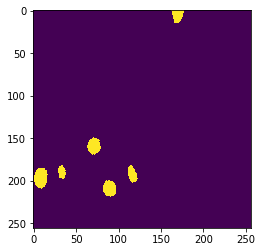

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


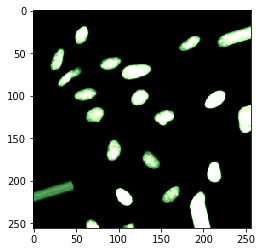

(256, 256, 1)


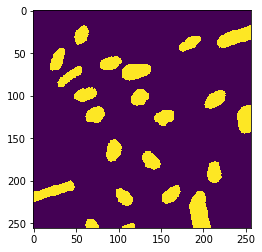

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


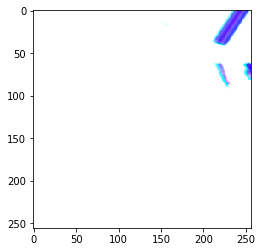

(256, 256, 1)


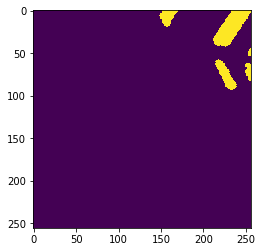

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


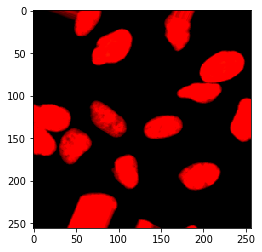

(256, 256, 1)


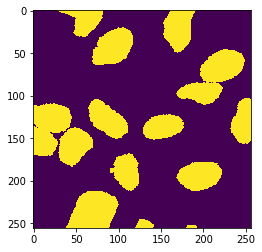

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


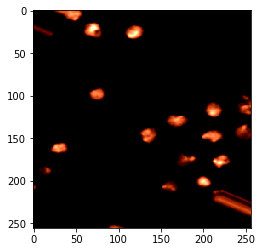

(256, 256, 1)


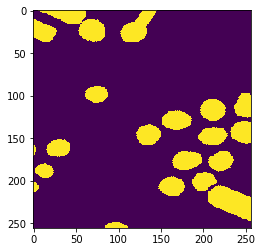

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


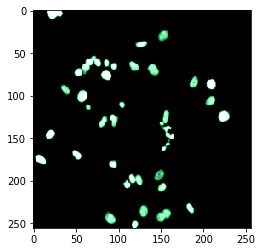

(256, 256, 1)


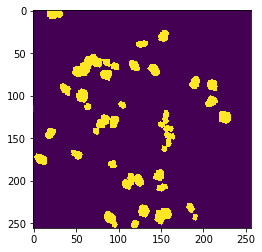

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


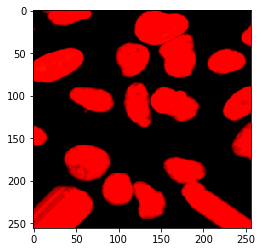

(256, 256, 1)


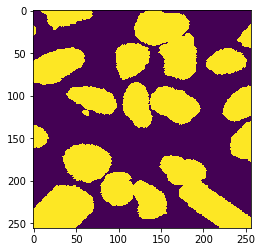

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


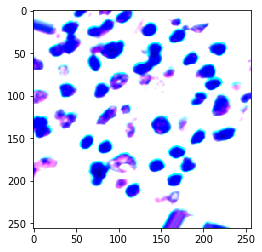

(256, 256, 1)


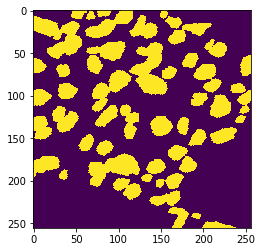

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


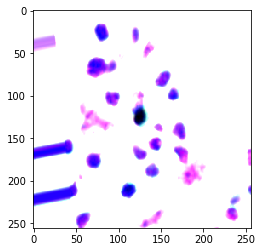

(256, 256, 1)


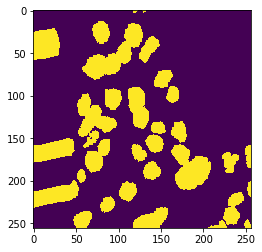

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


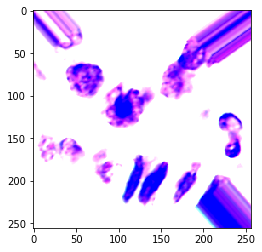

(256, 256, 1)


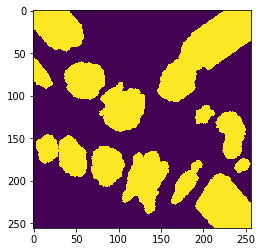

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


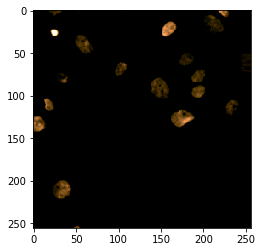

(256, 256, 1)


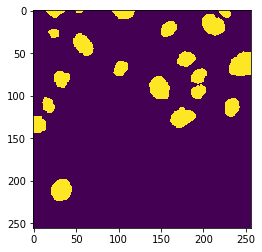

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


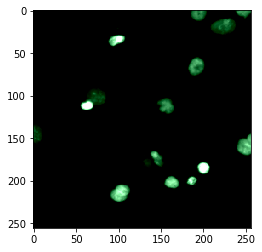

(256, 256, 1)


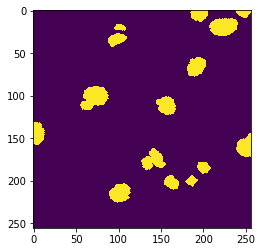

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


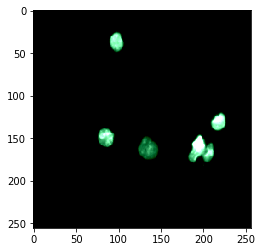

(256, 256, 1)


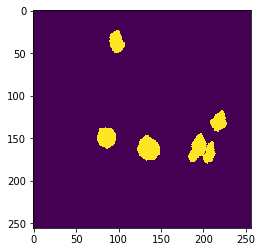

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


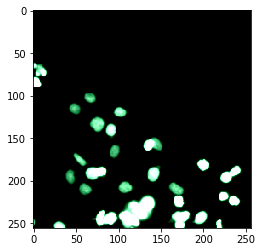

(256, 256, 1)


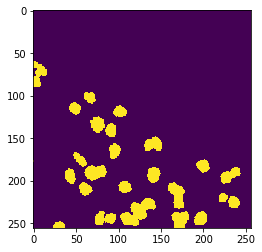

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


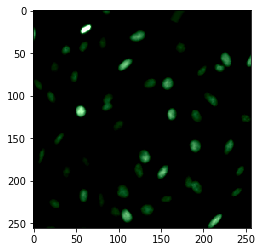

(256, 256, 1)


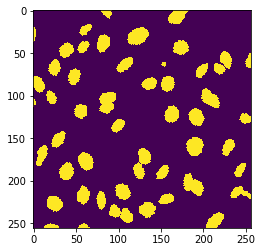

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


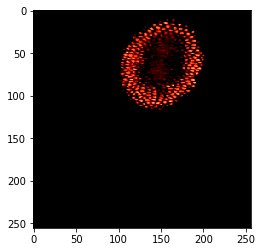

(256, 256, 1)


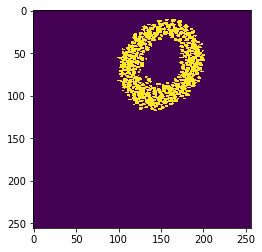

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


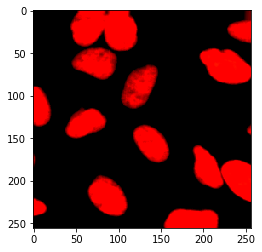

(256, 256, 1)


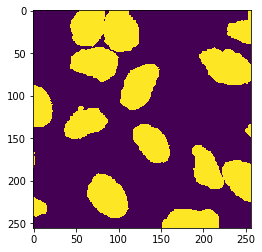

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


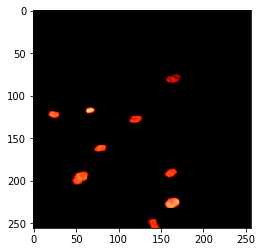

(256, 256, 1)


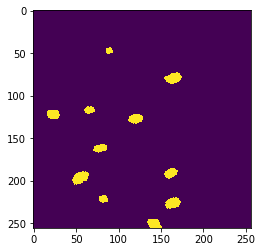

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


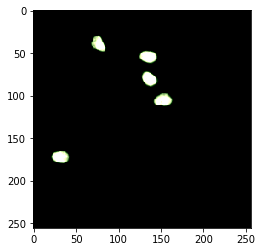

(256, 256, 1)


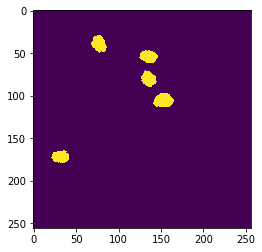

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


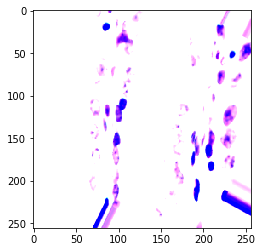

(256, 256, 1)


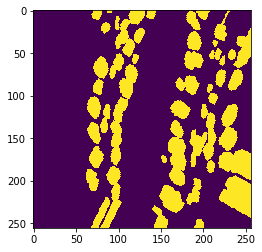

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


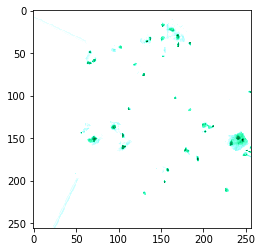

(256, 256, 1)


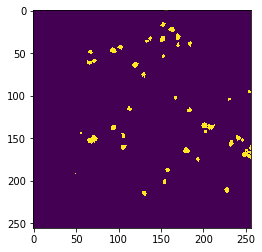

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


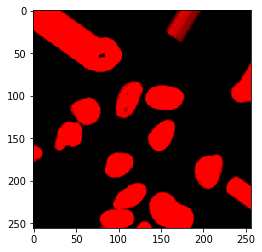

(256, 256, 1)


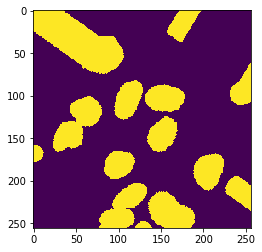

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


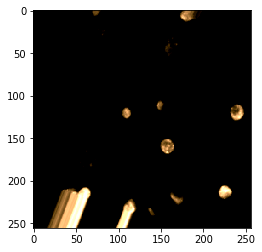

(256, 256, 1)


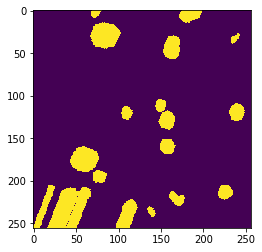

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


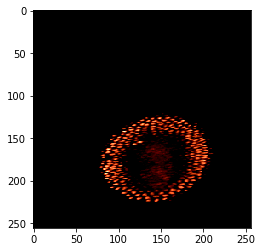

(256, 256, 1)


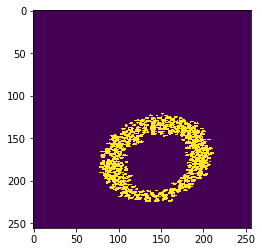

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


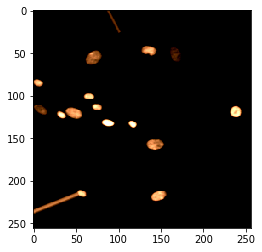

(256, 256, 1)


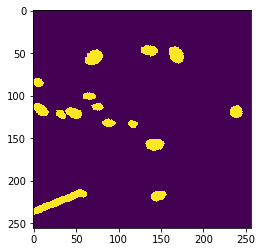

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


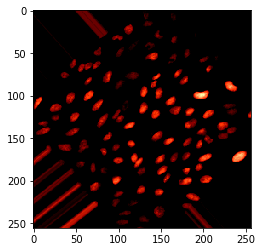

(256, 256, 1)


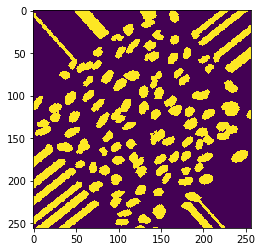

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


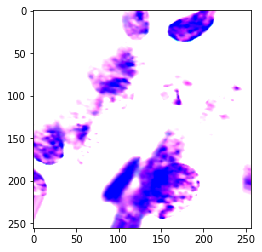

(256, 256, 1)


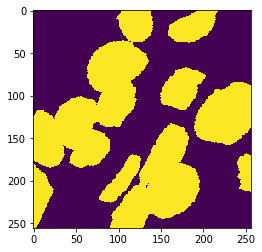

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


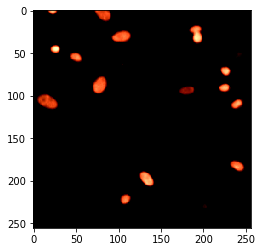

(256, 256, 1)


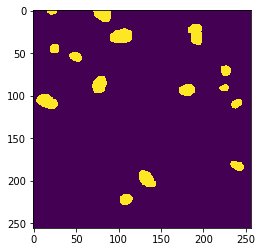

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


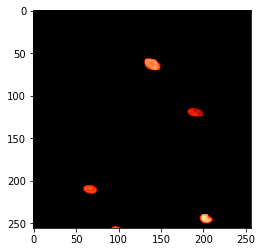

(256, 256, 1)


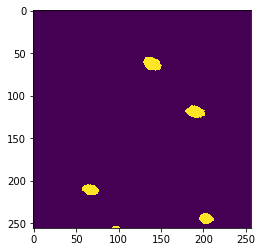

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


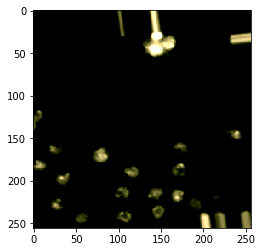

(256, 256, 1)


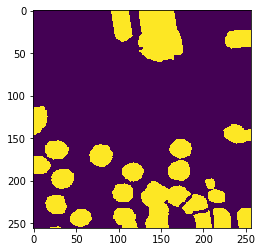

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


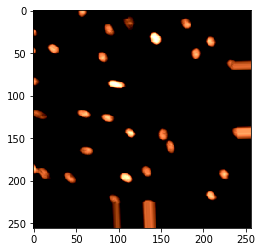

(256, 256, 1)


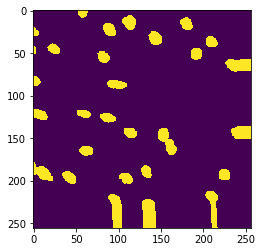

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


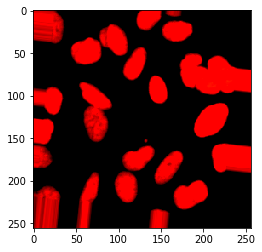

(256, 256, 1)


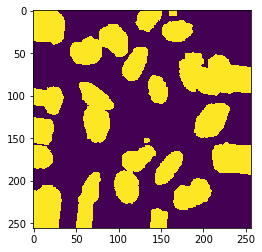

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


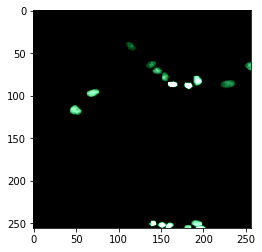

(256, 256, 1)


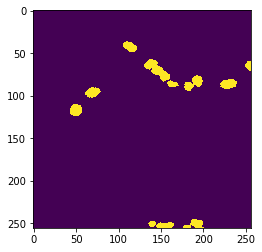

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


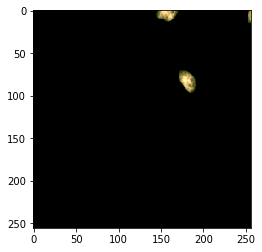

(256, 256, 1)


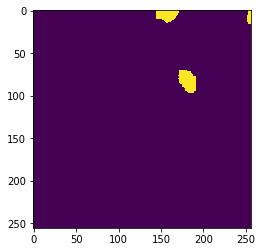

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


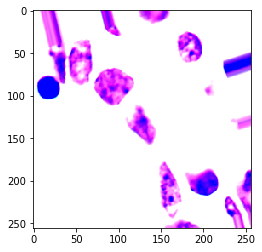

(256, 256, 1)


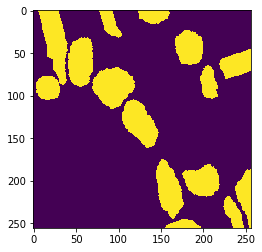

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


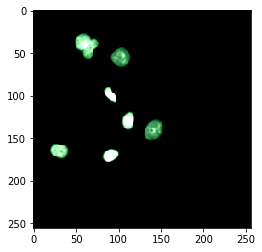

(256, 256, 1)


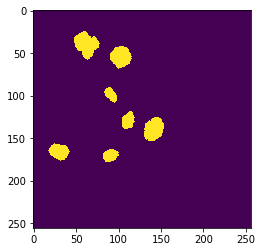

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


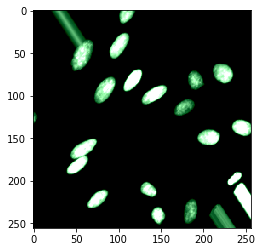

(256, 256, 1)


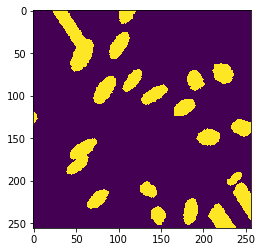

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


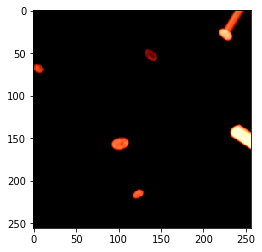

(256, 256, 1)


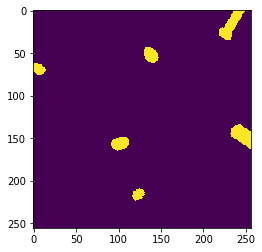

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


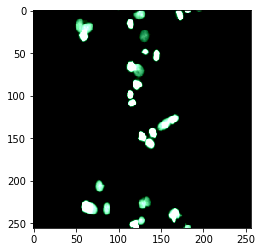

(256, 256, 1)


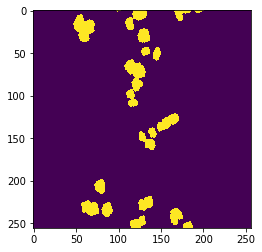

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


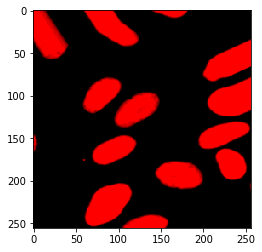

(256, 256, 1)


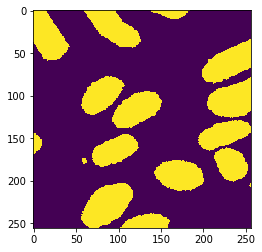

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


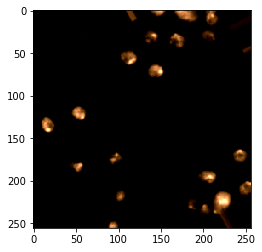

(256, 256, 1)


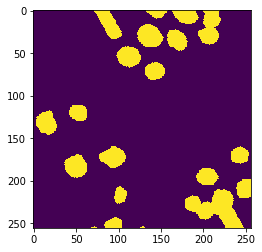

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


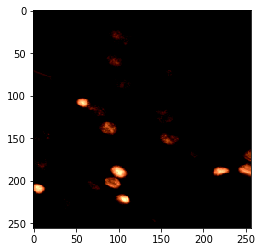

(256, 256, 1)


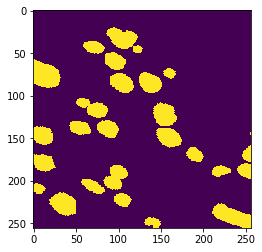

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


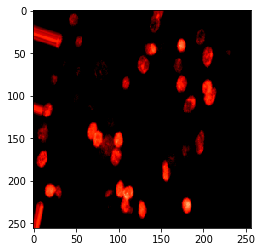

(256, 256, 1)


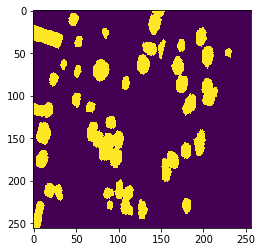

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


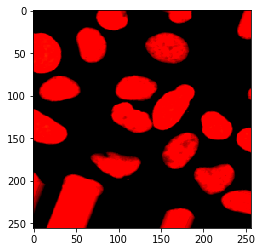

(256, 256, 1)


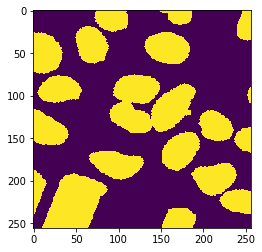

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


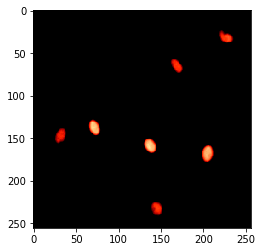

(256, 256, 1)


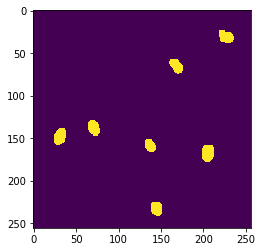

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


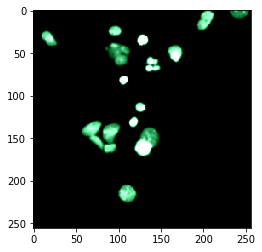

(256, 256, 1)


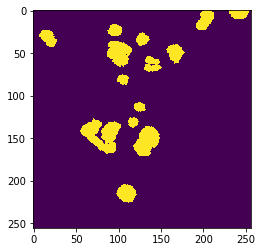

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


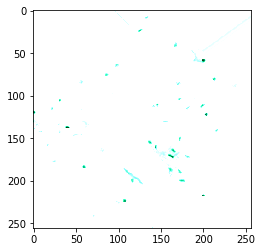

(256, 256, 1)


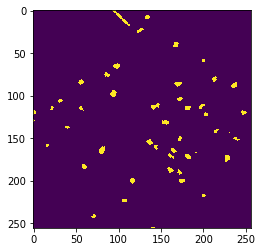

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


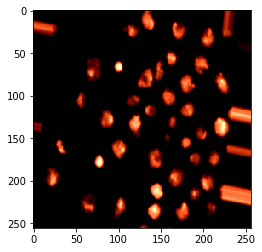

(256, 256, 1)


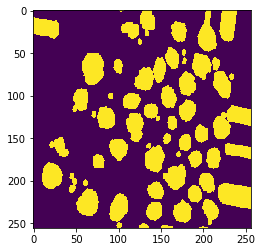

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


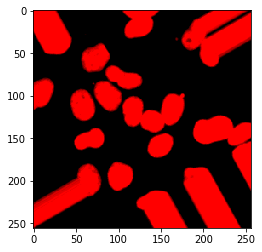

(256, 256, 1)


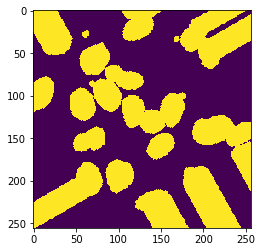

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


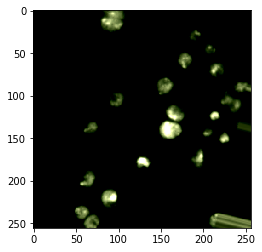

(256, 256, 1)


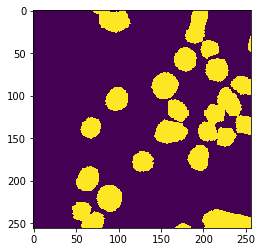

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


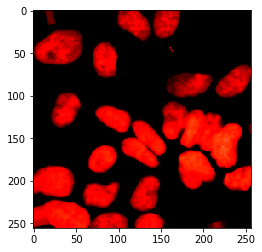

(256, 256, 1)


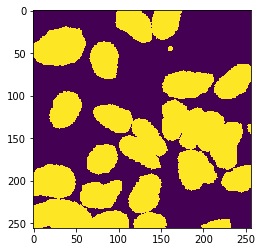

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


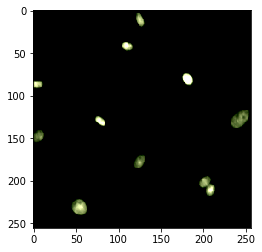

(256, 256, 1)


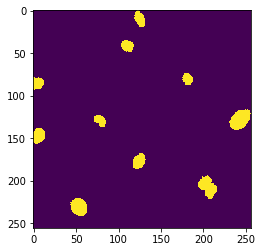

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


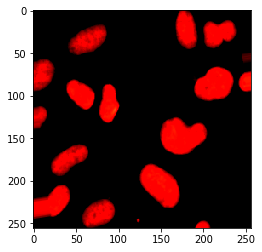

(256, 256, 1)


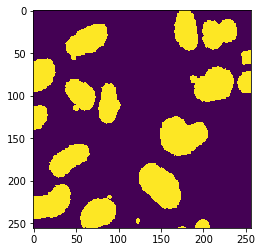

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


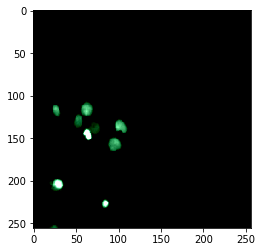

(256, 256, 1)


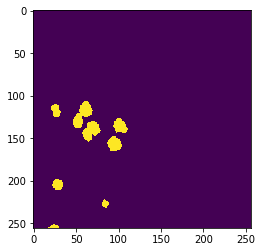

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


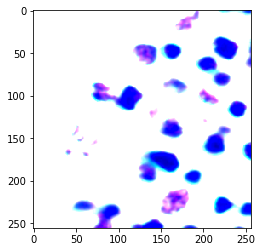

(256, 256, 1)


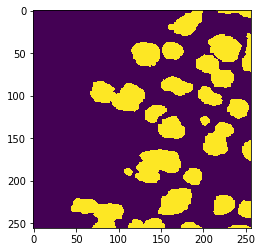

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


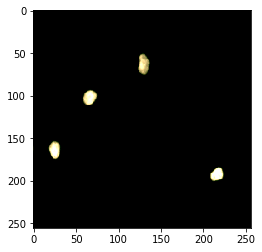

(256, 256, 1)


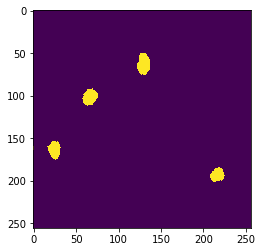

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


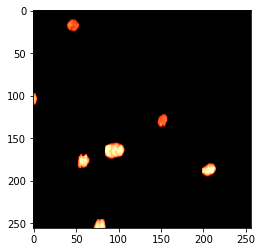

(256, 256, 1)


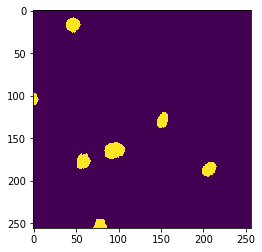

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


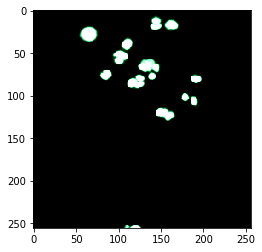

(256, 256, 1)


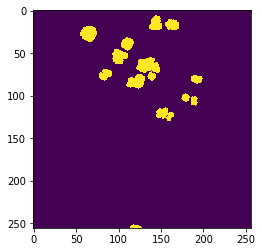

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


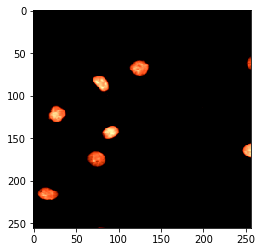

(256, 256, 1)


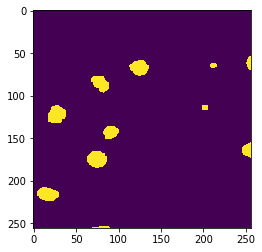

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


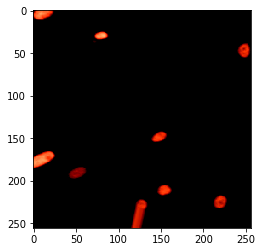

(256, 256, 1)


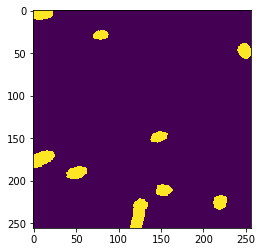

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


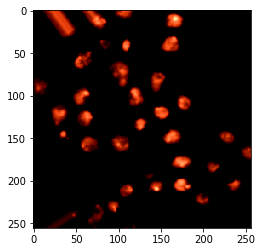

(256, 256, 1)


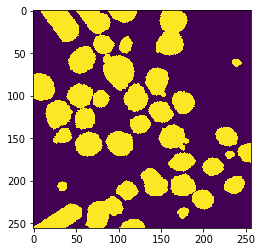

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


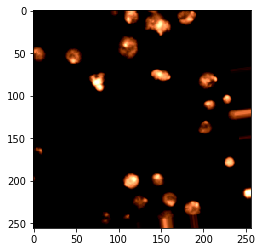

(256, 256, 1)


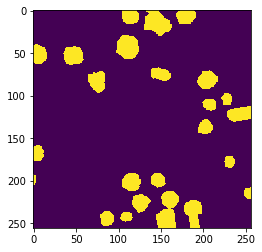

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


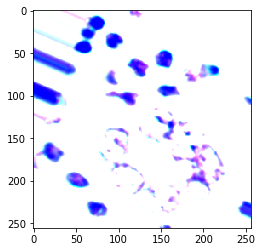

(256, 256, 1)


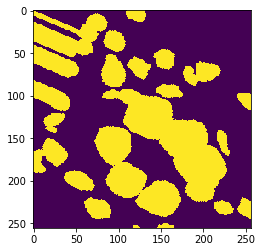

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


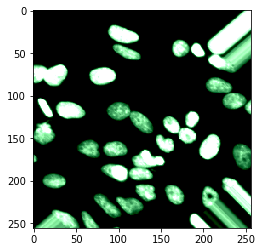

(256, 256, 1)


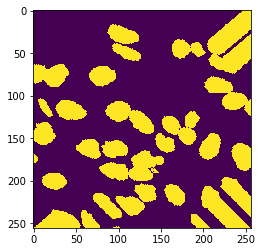

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


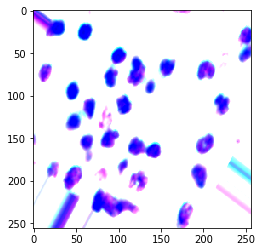

(256, 256, 1)


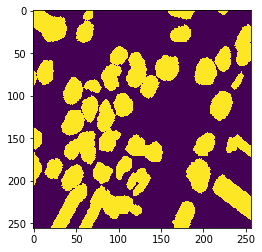

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


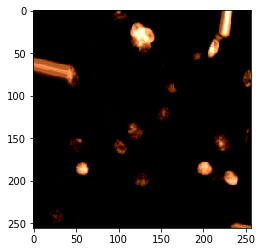

(256, 256, 1)


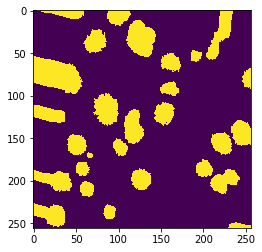

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


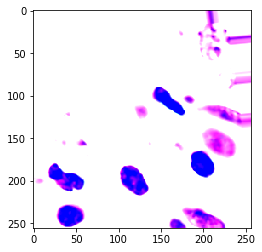

(256, 256, 1)


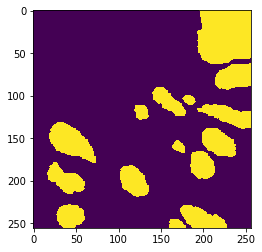

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


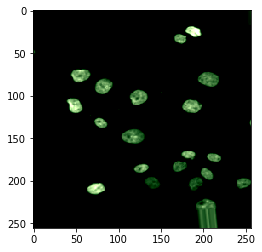

(256, 256, 1)


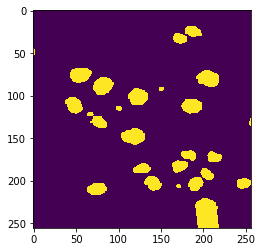

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


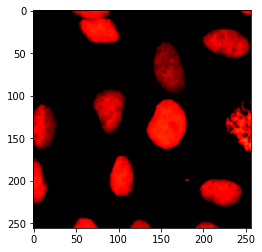

(256, 256, 1)


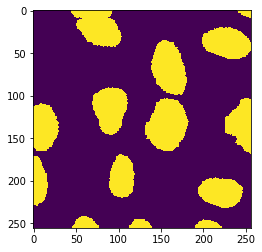

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


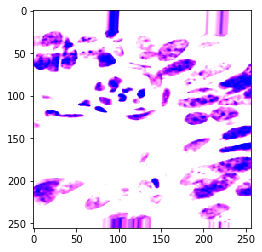

(256, 256, 1)


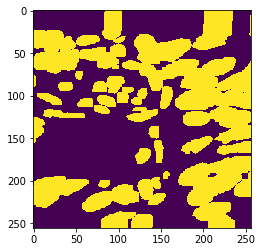

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


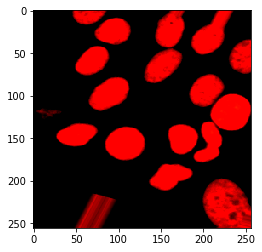

(256, 256, 1)


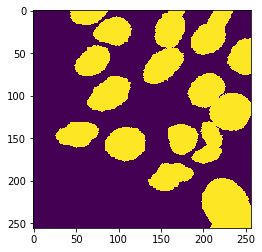

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


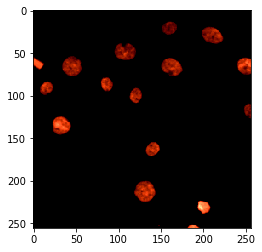

(256, 256, 1)


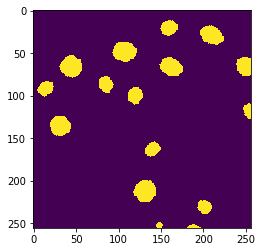

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


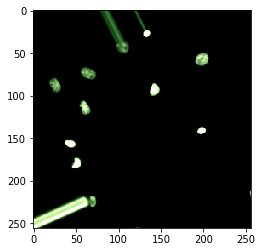

(256, 256, 1)


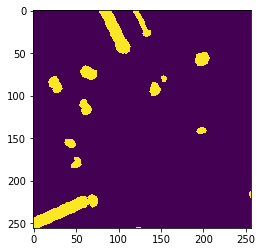

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


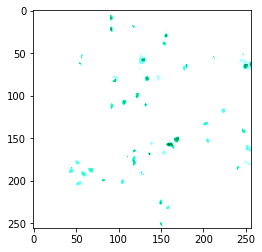

(256, 256, 1)


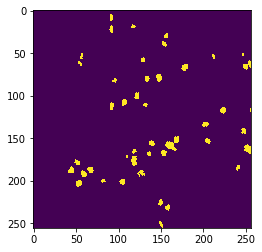

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


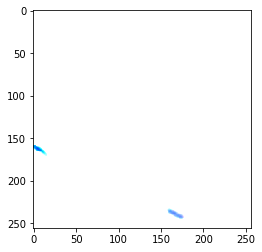

(256, 256, 1)


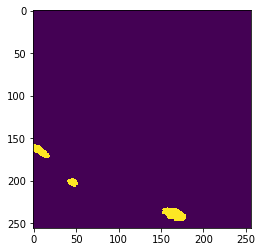

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


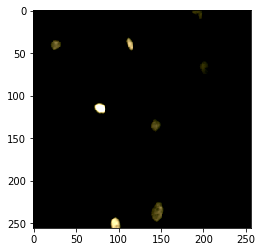

(256, 256, 1)


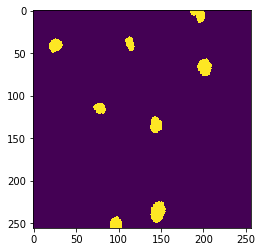

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


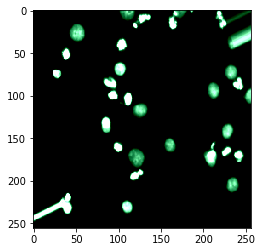

(256, 256, 1)


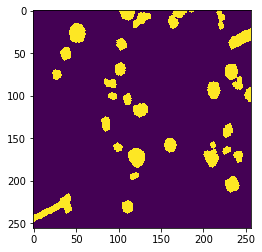

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


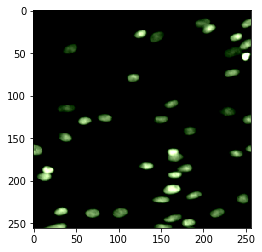

(256, 256, 1)


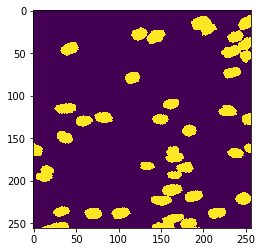

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


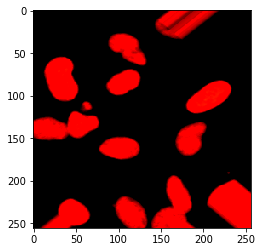

(256, 256, 1)


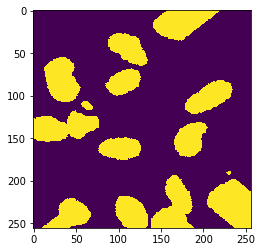

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


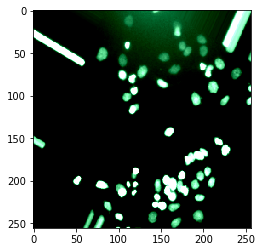

(256, 256, 1)


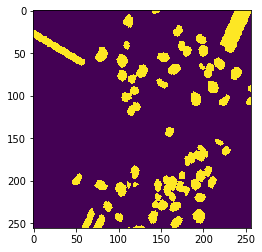

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


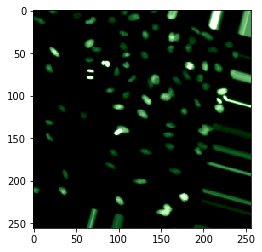

(256, 256, 1)


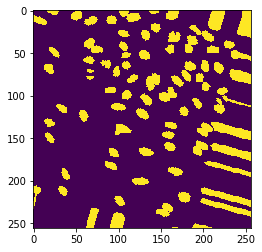

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


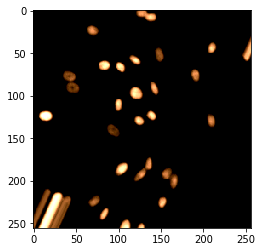

(256, 256, 1)


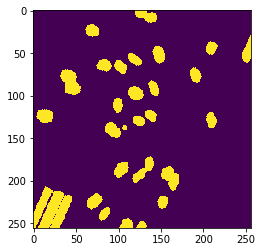

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


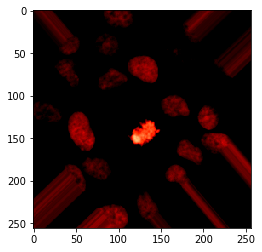

(256, 256, 1)


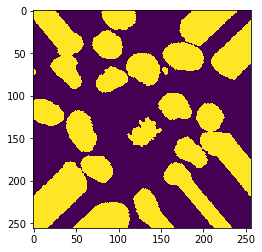

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


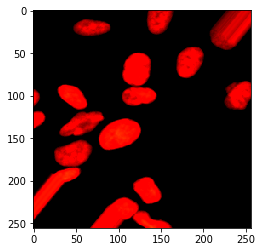

(256, 256, 1)


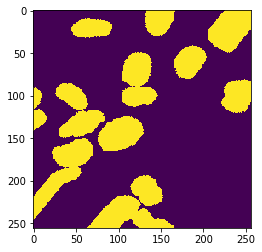

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


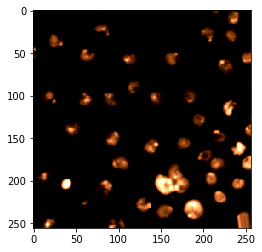

(256, 256, 1)


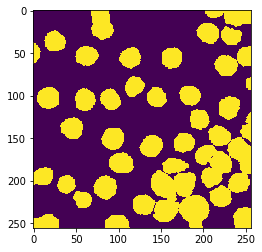

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


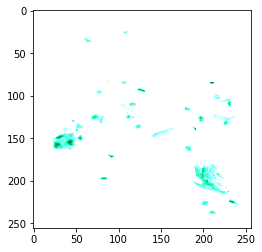

(256, 256, 1)


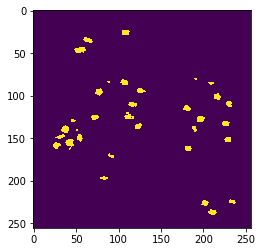

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


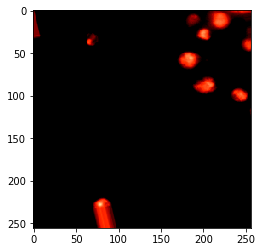

(256, 256, 1)


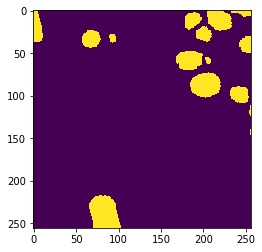

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


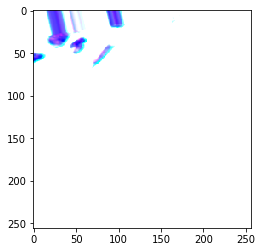

(256, 256, 1)


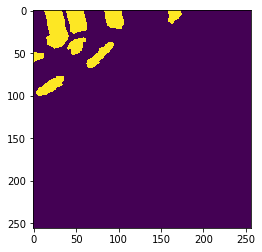

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


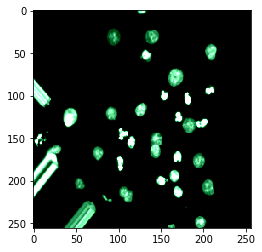

(256, 256, 1)


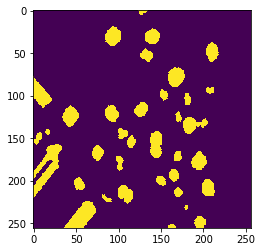

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


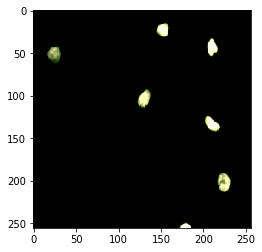

(256, 256, 1)


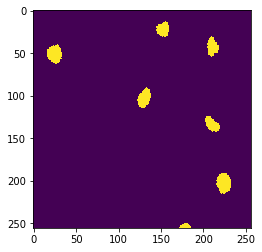

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


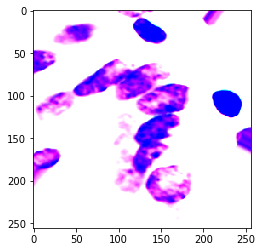

(256, 256, 1)


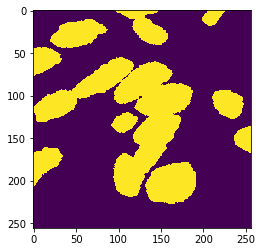

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


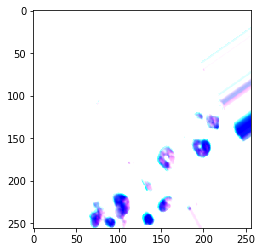

(256, 256, 1)


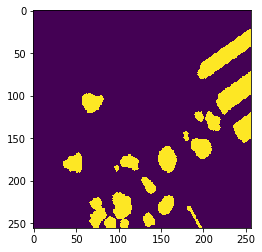

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


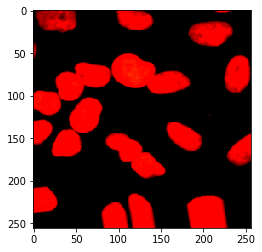

(256, 256, 1)


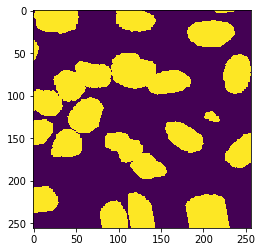

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


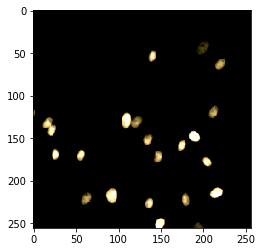

(256, 256, 1)


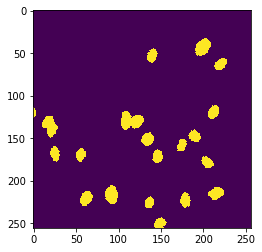

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


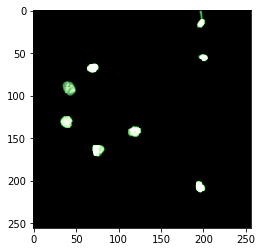

(256, 256, 1)


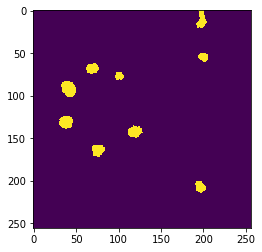

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


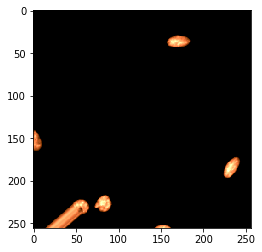

(256, 256, 1)


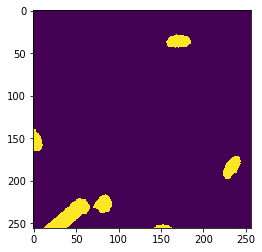

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


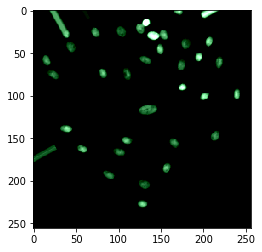

(256, 256, 1)


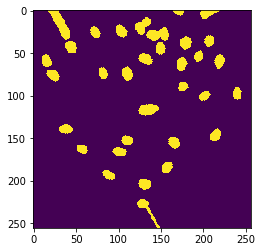

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


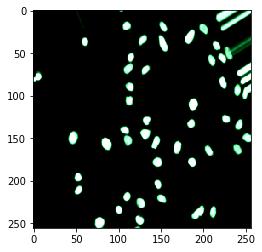

(256, 256, 1)


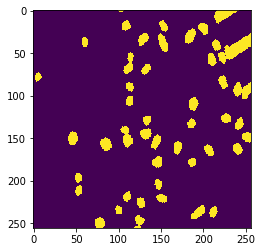

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


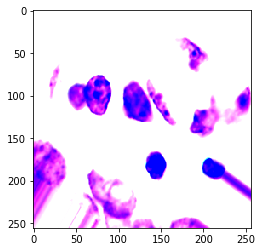

(256, 256, 1)


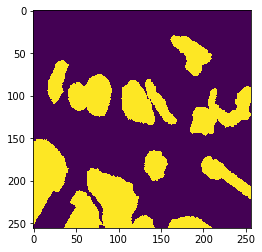

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


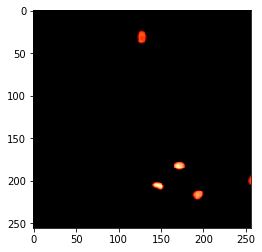

(256, 256, 1)


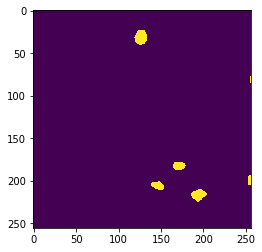

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


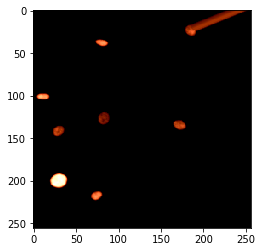

(256, 256, 1)


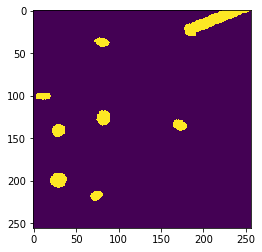

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


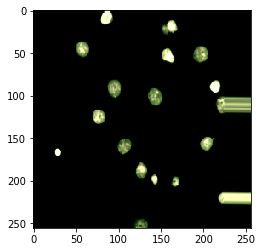

(256, 256, 1)


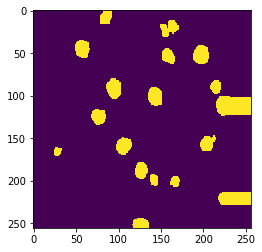

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


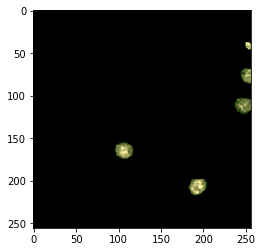

(256, 256, 1)


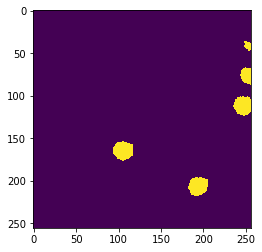

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


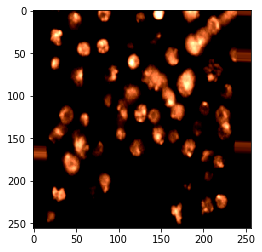

(256, 256, 1)


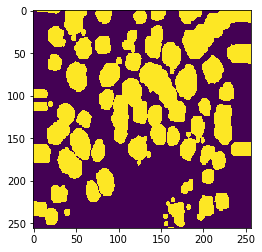

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


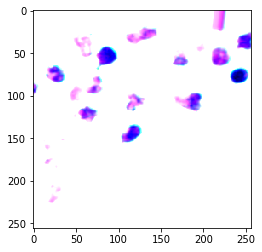

(256, 256, 1)


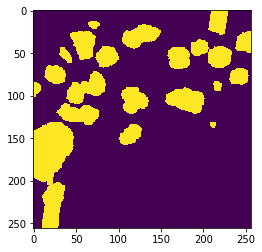

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


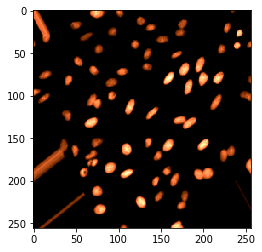

(256, 256, 1)


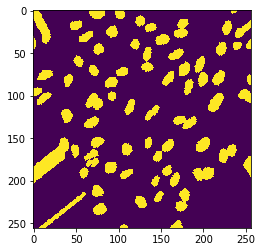

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


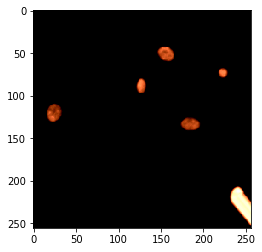

(256, 256, 1)


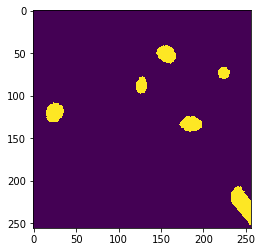

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


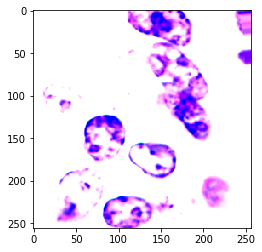

(256, 256, 1)


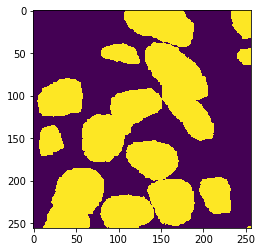

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


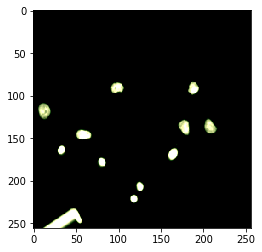

(256, 256, 1)


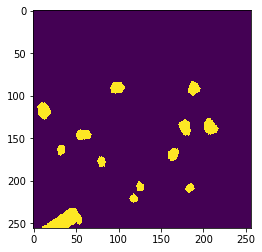

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


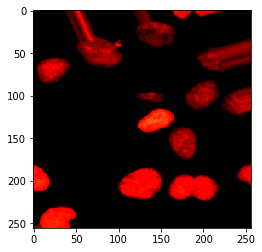

(256, 256, 1)


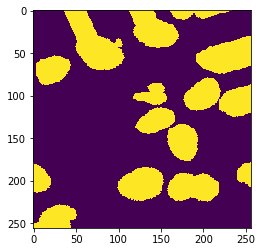

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


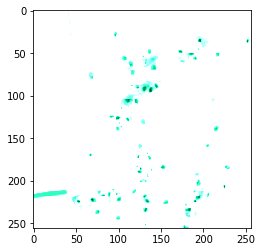

(256, 256, 1)


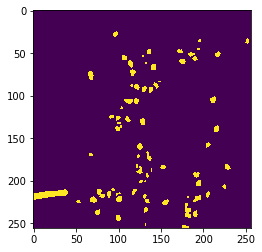

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


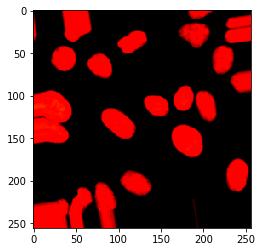

(256, 256, 1)


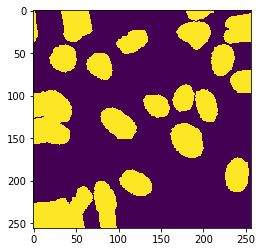

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


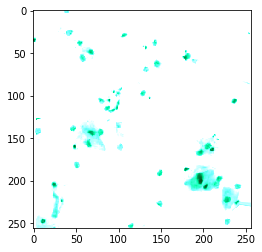

(256, 256, 1)


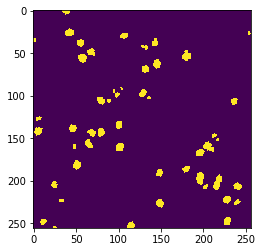

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


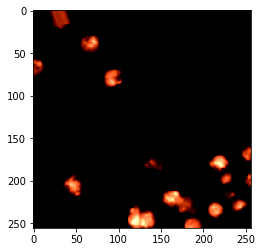

(256, 256, 1)


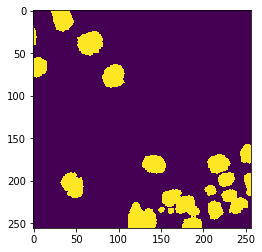

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


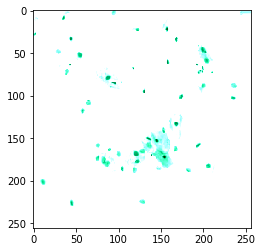

(256, 256, 1)


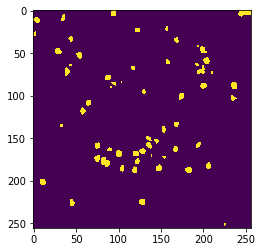

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


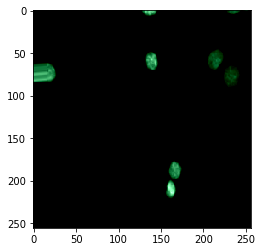

(256, 256, 1)


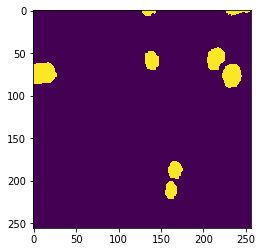

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


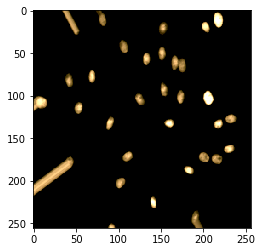

(256, 256, 1)


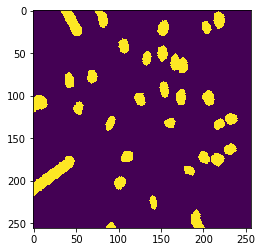

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


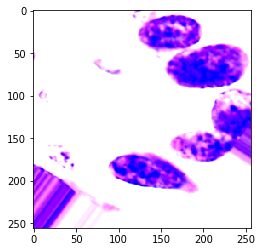

(256, 256, 1)


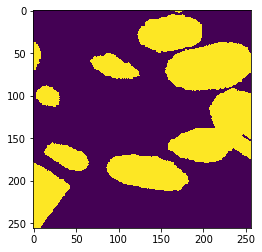

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


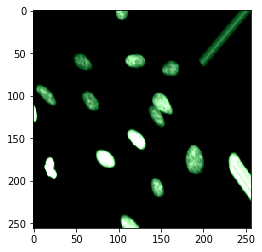

(256, 256, 1)


KeyboardInterrupt: 

In [54]:
for i in range(0, len(images)):
    im = images[i]    
    print(im.shape)
    plt.imshow(im)
    plt.show()
    
    ma = masks[i]
    print(ma.shape)
    plt.imshow(np.squeeze(ma))
    plt.show()

# Build and train neural network

In [13]:
u_net = model.build_model(_imgWidth, _imgWidth, _imgChannels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [44]:
model.fit_model(u_net, _modelDir, images, masks, _validationSplit, _epochs, _batchSize)

Train on 270 samples, validate on 30 samples
Epoch 1/50
270/270 [==============================] - 1s 5ms/step - loss: 0.6957 - dice_coef: 0.7761 - binary_accuracy: 0.7676 - val_loss: 0.4973 - val_dice_coef: 0.8242 - val_binary_accuracy: 0.8095

Epoch 00001: val_loss improved from inf to 0.49733, saving model to /home/Deep_Learner/work/U-Net/logs/2018-05-30 16:11:33/epoch0001-val_loss0.50.h5
Epoch 2/50
270/270 [==============================] - 1s 5ms/step - loss: 0.4541 - dice_coef: 0.8276 - binary_accuracy: 0.8369 - val_loss: 0.4899 - val_dice_coef: 0.8156 - val_binary_accuracy: 0.8095

Epoch 00002: val_loss improved from 0.49733 to 0.48990, saving model to /home/Deep_Learner/work/U-Net/logs/2018-05-30 16:11:33/epoch0002-val_loss0.49.h5
Epoch 3/50
270/270 [==============================] - 1s 5ms/step - loss: 0.4479 - dice_coef: 0.8287 - binary_accuracy: 0.8369 - val_loss: 0.4958 - val_dice_coef: 0.8299 - val_binary_accuracy: 0.8095

Epoch 00003: val_loss did not improve from 0.48990

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [62]:
preds_train_t, preds_val_t, preds_test_upsampled = model.make_predictions('./logs/2018-05-30 15:36:17/epoch0026-val_loss0.16.h5', X_train, X_val, X_test, sizes_test)

3018/3018 [==============================] - 4s 1ms/step


/tmp/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


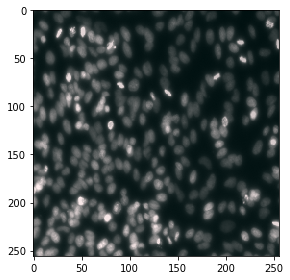

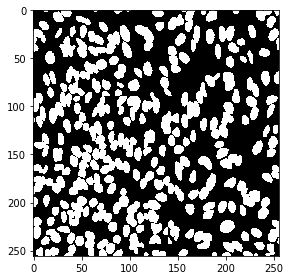

/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


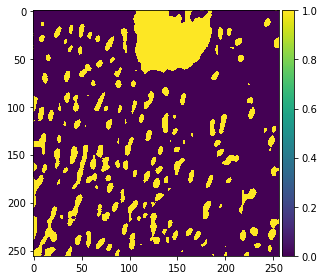

In [63]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

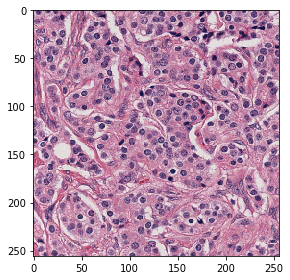

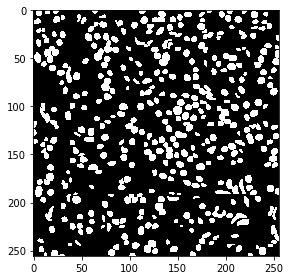

/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


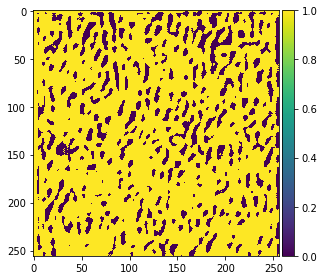

In [64]:
# Perform a sanity check on some random validation samples
"""
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
"""
ix = random.randint(0, len(preds_val_t))
imshow(X_val[ix])
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

and the test data:

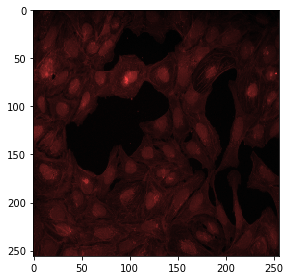

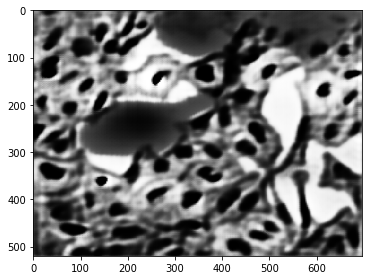

In [65]:
# Perform a sanity check on some random test sample
ix = random.randint(0, len(preds_test_upsampled))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_upsampled[ix]))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [36]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(utils.prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [37]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submissions/sub-dsbowl2018-U-Net_11.csv', index=False)